Código para guardar desde mongodb local
```python
from pymongo import MongoClient, ASCENDING
import json

c = MongoClient('localhost', 27018)


def _ser(e):
    e['_id'] = str(e['_id'])
    e['ts'] = e['ts'].isoformat()
    e['hum_ts'] = e['hum_ts'].isoformat()
    e['prc_ts'] = e['prc_ts'].isoformat()
    e['tmp_ts'] = e['tmp_ts'].isoformat()
    e['wnd_ts'] = e['wnd_ts'].isoformat()
    return e

def _save_data(fname):
    data = [ser(e) for e in c.dmc.data.find({}).sort('ts',ASCENDING)]
    with open(fname, 'w') as f:
        json.dump(data, f)

_save_data('meteo-data.json')
```

In [75]:
# imports

# parser.parse(): isodate to datetime.datetime
import dateutil.parser

# gráficos
%matplotlib inline
import matplotlib.pyplot as plt

# utilidad
def plot(save, title, xlabel, ylabel, plot_fn, *args, **kwargs):
    if not save.endswith('.png'):
        save += '.png'
    plt.figure(figsize=(20,10))
    plt.tick_params(labelsize=20)
    plot_fn(*args, **kwargs)
    plt.title(title, fontsize=30)
    plt.xlabel(xlabel, fontsize=24)
    plt.ylabel(ylabel, fontsize=24)
    plt.savefig(save)
    plt.show()

# Carga de datos

A continuación se definen funciones para cargar datos:

- Meteorológicos
- de Incendios

In [40]:
def load_meteo_data(fname):
    '''Carga archivo .json con información de meteorología,
    '''
    def de(e):
        e['ts'] = dateutil.parser.parse(e['ts'])
        e['hum_ts'] = dateutil.parser.parse(e['hum_ts'])
        e['prc_ts'] = dateutil.parser.parse(e['prc_ts'])
        e['tmp_ts'] = dateutil.parser.parse(e['tmp_ts'])
        e['wnd_ts'] = dateutil.parser.parse(e['wnd_ts'])
        return e
        
    with open(fname, 'r') as f:
        return [de(e) for e in json.load(f)]

def load_wildfire_data(filename):
    with open(filename) as f:
        wildfires = json.load(f)
    for w in wildfires:
        w['start'] = dateutil.parser.parse(w['start'])
    return sorted(wildfires, key=lambda x: x['start'])

In [41]:
d = load_meteo_data('meteo-data.json')
w = load_wildfire_data('wz3ext.json')

# Formatos

## Datos Meteorológicos

| Nombre  | descripción                                   | tipo     |
| ------- | --------------------------------------------- | -------- |
| _id     | id mongodb                                    | str      |
| ts      | timestamp dato                                | datetime |
| dev     | id estación meteorológica                     | int      |
| hum     | humedad relativa (%)                          | float    |
| hum_ts  | timestamp asociado a humedad                  | datetime |
| prc     | precipitación (mm)                            | float    |
| prc_ts  | timestamp asociado a precipitación            | datetime |
| tmp     | temperatura (°C)                              | float    |
| tmp_ts  | timestamp asociado a temperatura              | float    |
| wnd     | velocidad del viento (km/h)                   | float    |
| wnd_dir | dirección viento (°)                          | int      |
| wnd_ts  | timestamp asociado a viento                   | datetime |
| valid   | verdadero si es que todos los _ts son iguales | bool     |

*La razón de tener distintos timestamp por cada valor es que no a todas horas se tiene un valor para la variable en cuestión.

## Datos de Incendios

| Nombre      | descripción                                     | tipo     |
| ----------- | ----------------------------------------------- | -------- |
| lat         | latitud                                         | float    |
| lon         | longitud                                        | float    |
| start       | inicio del incendio                             | datetime |
| duration    | duración (h)                                    | float    |
| cause       | causa registrada                                | str      |
| distance_to | distancia (km) desde una estación meteorológica | dict     |

# Análisis de Causas

A continuación se revisan los datos de incendios de la zona 3 (ver Tabla 6, documento de memoria) en búsqueda de las causas de ignición registradas más comunes.

Se obtienen las posibles causas y la cantidad de ocurrencias:

In [51]:
def cause_code(cause):
    return cause[:cause.find('. ') + 1]

def cause_cmp(cause):
    M, m, p, _ = cause_code(cause).split('.')
    return int(M) * 1000 + int(m) * 100 + int(p)

# wz1 < wz2 < wz3
causes = {}
for wi in w:
    if wi['cause'] in causes:
        causes[wi['cause']] += 1
    else:
        causes[wi['cause']] = 1

for cause in sorted(causes.keys(), key=cause_cmp):
    print(f"[{cause_code(cause)[:-1]}] {cause[len(cause_code(cause))+1:]} ({causes[cause]} ocurrencia{'s' if causes[cause]>1 else ''})")

[1.1.2] Quema ilegal de desechos de cosecha forestal (quema para reforestación) (1 ocurrencia)
[1.1.5] Quema legal de habilitación de terreno forestal (quema para forestación) (1 ocurrencia)
[1.1.19] Chispa  maquinaria en faena forestal (skidder  tractor  vehí­culo liviano y pesado) (1 ocurrencia)
[1.4.1] Uso de fuego para actividades recreativas en áreas no habilitadas  (excursionistas  paseantes  asados) (2 ocurrencias)
[1.4.5] Niños jugando con fuego (23 ocurrencias)
[1.6.3] Incendio estructural (campamento forestal  casa habitación u otras edificaciones) (5 ocurrencias)
[1.7.1] Uso de fuego por transeúntes (304 ocurrencias)
[1.7.3] Accidente o incendio de vehí­culo en tránsito (1 ocurrencia)
[1.8.1] Quema de basuras  desechos vegetales u otros no clasificados (distintos de vertederos o basurales autorizados) (5 ocurrencias)
[1.8.2] Quema legal de aserrí­n o aserrí­n encendido (1 ocurrencia)
[1.8.14] Encendido de vertederos o basurales autorizados  (1 ocurrencia)
[1.9.3] Corte de ca

Luego podemos definir las causas legales:

In [52]:
def cause_is_legal(cause):
    return\
        cause.startswith('1.1.5.') or\
        cause.startswith('1.8.1.') or\
        cause.startswith('1.8.2') or\
        cause.startswith('1.8.14')

Finalmente se genera un gráfico de cantidad de ocurrencias (log) por categorías, donde se marca con azul las causas legales:

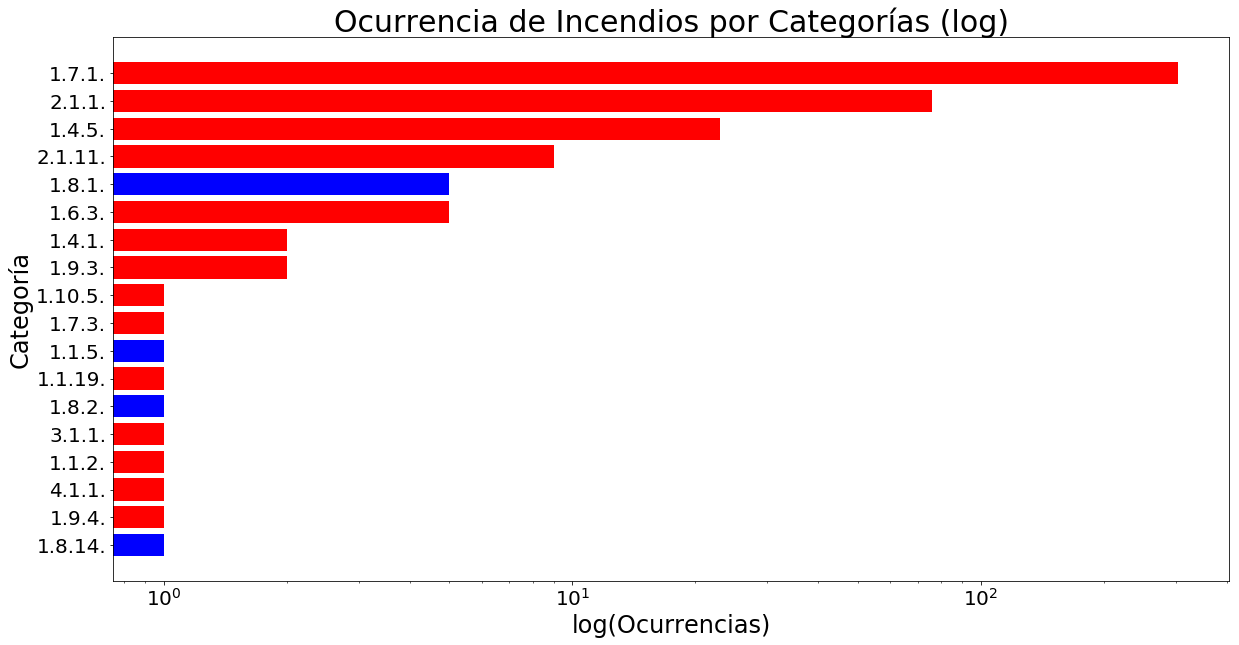

In [77]:
sorted_causes = sorted(causes.items(), key=lambda x: x[1])

x_cause = [cause_code(i[0]) for i in sorted_causes]
y_cause = [i[1] for i in sorted_causes] # occurrences
c_cause = ['blue' if cause_is_legal(c[0]) else 'red' for c in sorted_causes]

plot('incendios-categoria-ocurrencia',
    'Ocurrencia de Incendios por Categorías (log)',
    'log(Ocurrencias)',
    'Categoría',
     plt.barh,
         x_cause,
         y_cause,
         color=c_cause,
         log=True)

# Análisis de Lluvias

Ver *Drought.ipynb*
